# Generalidades

En el siguiente documento se encuentran las implementaciones del laboratorio pasado. Se incluye el mismo problema que se identifico en el informe, los parámetros, las variables, el modelo y las restricciones.

## Miembros
- Javier Barrera - 2022164779
- Julian Rolon - 20221****

In [140]:
from pyomo.environ import ConcreteModel, RangeSet, \
    Param, Var, Binary, \
    Objective, maximize, Constraint, value

from matplotlib import pyplot as plt
import matplotlib.patches as mpatches

from pyomo.opt import SolverFactory

# Punto 1

## Parte A

### Problema
El problema del SCRUM master es asignar las tareas a un equipo de desarrolladores maximizando la prioridad de las mismas teniendo en cuenta que el equipo
puede desarrollar un máximo de 52 puntos de historia. Para dar un poco más de contexto,
se nos propone que las tareas tienen una prioridad y unos puntos de historia, que entre
mayor sea el número mayor será el esfuerzo requerido para finalizar una.

### Parámetros del modelo

Definamos las tareas como $T = T_1, T_2, \dots, T_{11}$. Además, cada $i \in T$ tarea tiene asignada unos puntos de historia $p_i$ y una prioridad $w_i$. Adicionalmente definamos $H^{*}$ como el número máximo de puntos de historia que va a desarrollar el equipo durante el sprint. En este punto surge una tarea adicional, la prioridad es una variable categoría, debemos representar esto de alguna manera en el modelo. Lo más sencillo que se puede realizar es ordenar de menor a mayor las prioridades y asignarles un número entero de $0$ a $k$, siendo $k$ la mayor prioridad.

### Variable de decisión

En cuanto a la variable de decisión tenemos que será $X$, un arreglo uní dimensional binario que tiene el mismo tamaño que el número de tareas. Este arreglo tendrá entradas con $1$ o $0$, dependiendo si se asigno la tarea al equipo o no.

In [141]:
tasks_num = 11
max_points = 52

model = ConcreteModel()

# sets
model.T = RangeSet(1, tasks_num) # 1, 2, ..., 11

# params
ph = [5, 3, 13, 1, 21, 2, 2, 5, 8, 13, 21]
priority = [7, 5, 6, 3, 1, 4, 6, 6, 2, 7, 6]
dict_ph = {i+1: ph[i] for i in range(tasks_num)}
dict_priority = {i+1: priority[i] for i in range(tasks_num)}

model.h_points = Param(model.T, initialize=dict_ph)
model.priority = Param(model.T, initialize=dict_priority)
model.max_points = Param(initialize=max_points)

# dec. variable
model.X = Var(model.T, within=Binary)

### Función objetivo
Finalmente, la función objetivo es la siguiente:

$$ Z = \max \sum_{i \in T} w_i \times X_i $$

In [142]:
# obj. function
def obj_func(model):
    return sum(model.priority[i] * model.X[i] for i in model.T)

model.obj = Objective(rule=obj_func, sense=maximize)

### Restricciones

Hay una restricción sobre los puntos de historias de usuario. En este caso el maximo de punto de las tareas asignadas al equipo son 52 puntos.

$$ \sum_{i \in T} X_i \times p_i \leq H^{*} $$

In [143]:
if hasattr(model, "max_history_points"):
    model.del_component(model.max_history_points)

def constraint_max_history_points(model):
    return sum(model.X[i] * model.h_points[i] for i in model.T) <= model.max_points

model.max_history_points = Constraint(rule=constraint_max_history_points)

### Solución del modelo

In [144]:
solver = SolverFactory('glpk')
solver.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\javier\AppData\Local\Temp\tmpxv4zavw9.glpk.raw --wglp C:\Users\javier\AppData\Local\Temp\tmpkrpbrqpf.glpk.glp
 --cpxlp C:\Users\javier\AppData\Local\Temp\tmpn14rkcul.pyomo.lp
Reading problem data from 'C:\Users\javier\AppData\Local\Temp\tmpn14rkcul.pyomo.lp'...
C:\Users\javier\AppData\Local\Temp\tmpn14rkcul.pyomo.lp:46: warning: lower bound of variable 'x2' redefined
C:\Users\javier\AppData\Local\Temp\tmpn14rkcul.pyomo.lp:46: warning: upper bound of variable 'x2' redefined
1 row, 11 columns, 11 non-zeros
11 integer variables, all of which are binary
57 lines were read
Writing problem data to 'C:\Users\javier\AppData\Local\Temp\tmpkrpbrqpf.glpk.glp'...
38 lines were written
GLPK Integer Optimizer 5.0
1 row, 11 columns, 11 non-zeros
11 integer variables, all of which are binary
Preprocessing...
1 row, 11 columns, 11 non-zeros
11 integer variables, all of which are binary
Scaling...
 A: min|aij| =

{'Problem': [{'Name': 'unknown', 'Lower bound': 46.0, 'Upper bound': 46.0, 'Number of objectives': 1, 'Number of constraints': 1, 'Number of variables': 11, 'Number of nonzeros': 11, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '1', 'Number of created subproblems': '1'}}, 'Error rc': 0, 'Time': 0.03692317008972168}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Resultados

In [145]:
print("### Resultados ###")
print("Tareas asignadas al equipo de desarrolladores: \n")
for i in model.T:
    if model.X[i].value == 1:
        print(f"[->] La tarea {i} con {model.h_points[i]} puntos de historia")

print()
total = sum(model.X[i].value * model.h_points[i] for i in model.T)

print(f"El total de puntos de historia utilizados son {total}")

### Resultados ###
Tareas asignadas al equipo de desarrolladores: 

[->] La tarea 1 con 5 puntos de historia
[->] La tarea 2 con 3 puntos de historia
[->] La tarea 3 con 13 puntos de historia
[->] La tarea 4 con 1 puntos de historia
[->] La tarea 6 con 2 puntos de historia
[->] La tarea 7 con 2 puntos de historia
[->] La tarea 8 con 5 puntos de historia
[->] La tarea 9 con 8 puntos de historia
[->] La tarea 10 con 13 puntos de historia

El total de puntos de historia utilizados son 52.0


### Visualización resultados

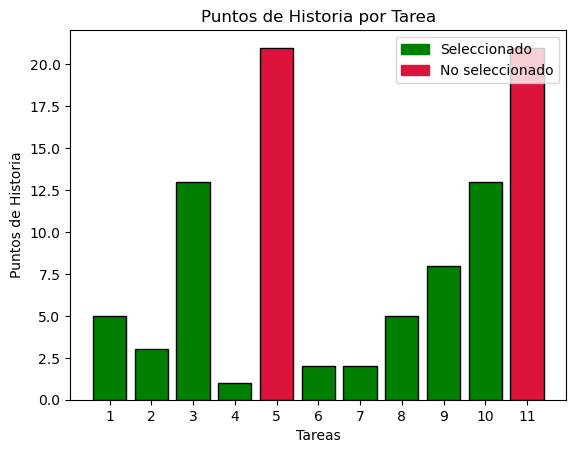

In [146]:
fig, axis = plt.subplots()

colors = ['green' if model.X[i].value == 1 else 'crimson' for i in model.T]

axis.bar(range(1, tasks_num + 1), ph, color=colors, edgecolor='black')

plt.xlabel("Tareas")
plt.ylabel("Puntos de Historia")
plt.title("Puntos de Historia por Tarea")
plt.xticks(range(1, tasks_num + 1))

green_patch = mpatches.Patch(color='green', label='Seleccionado')
blue_patch = mpatches.Patch(color='crimson', label='No seleccionado')
plt.legend(handles=[green_patch, blue_patch], loc='upper right')

plt.show()

## Parte B

### Problema 
Dado este nuevo contexto es necesario cambiar inicialmente el problema que se quiere realizar. En este caso será \textbf{maximizar} la prioridad de las tareas que se le asigna a cada desarrollador sin exceder un límite de 13 puntos de historia. Continuamos con las suposiciones que anteriormente se plantearon, solo que ahora no se va a tratar al equipo como 1 y las tareas no se pueden repartir entre dos o más desarrolladores.

### Parámetros y variable de decisión
También es necesario hacer cambios a los parámetros y la variable de decisión. Sobre los parámetros se redefinirá $H^{*}$ como el máximo de punto de historia que puede realizar cada uno de los desarrollador, igual para todos. Adicionalmente, se añadirán los desarrolladores $D = D_1, D_2, D_3, D_4$. Combinando los dos parámetros anteriores cada $j \in D$ desarrollador tiene cómo máximo de puntos de historia $H^{*}$. La variable de decisión ahora será una matriz binaria de tamaño número de desarrolladores por número de tareas. Sí la entrada $X_{i,j}$ es $1$ entonces el programador $i$ toma la tarea $j$, de lo contrario no la toma. 

In [147]:
tasks = 11
developers = 4
max_history_points_per_dev = 13

model = ConcreteModel()

model.T = RangeSet(1, tasks)
model.D = RangeSet(1, developers)

# parameters 
ph = [5, 3, 13, 1, 21, 2, 2, 5, 8, 13, 21]
priority = [7, 5, 6, 3, 1, 4, 6, 6, 2, 7, 6]
dict_ph = {i+1: ph[i] for i in range(tasks_num)}
dict_priority = {i+1: priority[i] for i in range(tasks_num)}

model.h_points = Param(model.T, initialize=dict_ph)
model.priority = Param(model.T, initialize=dict_priority)
model.max_h_points = Param(initialize=max_history_points_per_dev)

# decision variable
model.X = Var(model.D, model.T, within=Binary)

### Función objetivo
En cuanto a la función objetivo y las restricciones tenemos los siguiente. Para cada $j$ programador quiero **maximizar** la prioridad de las tareas que le asigno. 

$$
Z^{*} = \max \sum_{j\in D} \sum_{i \in T} X_{i,j} \times w_i
$$

In [148]:
def obj_func(model):
    return sum(model.X[i, j] * model.priority[j] for j in model.T for i in model.D)

model.obj = Objective(rule=obj_func, sense=maximize)

### Restricciones

Para todo $j \in D$ desarrollador existe un máximo de puntos de historia $H^{*}$.
$$
    \sum_{i \in T} X_{i,j} \times p_i \leq H^{*}, \forall j \in D
$$

Adicionalmente, toda $i \in T$ tarea solo puede ser asignada a un desarrollador. Por ejemplo, la tarea 1 no va a estar asignada al desarrollador 1 y al desarrollador 2, solo a uno de ellos.

$$
    \sum_{j \in D} X_{i,j} \leq 1, \forall i \in T
$$

In [149]:
def max_history_points_per_dev_constr(model, i):
    return sum(model.X[i, j] * model.h_points[j] for j in model.T) <= model.max_h_points

model.history_points_constr = Constraint(model.D, rule=max_history_points_per_dev_constr)

def assign_one_task_per_dev_constr(model, j):
    return sum(model.X[i,j] for i in model.D) <= 1

model.one_task_constr = Constraint(model.T, rule=assign_one_task_per_dev_constr)

### Solución del modelo

In [150]:
solver = SolverFactory('glpk')
solver.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\javier\AppData\Local\Temp\tmpwscn0qmi.glpk.raw --wglp C:\Users\javier\AppData\Local\Temp\tmpjsqcd6uo.glpk.glp
 --cpxlp C:\Users\javier\AppData\Local\Temp\tmp5qbmk4mm.pyomo.lp
Reading problem data from 'C:\Users\javier\AppData\Local\Temp\tmp5qbmk4mm.pyomo.lp'...
C:\Users\javier\AppData\Local\Temp\tmp5qbmk4mm.pyomo.lp:231: warning: lower bound of variable 'x2' redefined
C:\Users\javier\AppData\Local\Temp\tmp5qbmk4mm.pyomo.lp:231: warning: upper bound of variable 'x2' redefined
15 rows, 44 columns, 88 non-zeros
44 integer variables, all of which are binary
275 lines were read
Writing problem data to 'C:\Users\javier\AppData\Local\Temp\tmpjsqcd6uo.glpk.glp'...
209 lines were written
GLPK Integer Optimizer 5.0
15 rows, 44 columns, 88 non-zeros
44 integer variables, all of which are binary
Preprocessing...
13 rows, 36 columns, 72 non-zeros
36 integer variables, all of which are binary
Scaling...
 A: 

{'Problem': [{'Name': 'unknown', 'Lower bound': 46.0, 'Upper bound': 46.0, 'Number of objectives': 1, 'Number of constraints': 15, 'Number of variables': 44, 'Number of nonzeros': 88, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '5', 'Number of created subproblems': '5'}}, 'Error rc': 0, 'Time': 0.040074825286865234}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

### Resultados

In [151]:
print("### Resultados ###")
print("Tareas asignadas a cada desarrollador\n")

for i in model.D:

    print(f"[->] Desarrollador {i}")
    for j in model.T:
        if model.X[i, j].value == 1:
            print(f"\tTarea {j} con puntos {model.h_points[j]} de historia")
    print()

total = sum(model.X[i, j].value * model.h_points[j] for j in model.T for i in model.D)
print(f"Número total de puntos de historia: {total}")

### Resultados ###
Tareas asignadas a cada desarrollador

[->] Desarrollador 1
	Tarea 1 con puntos 5 de historia
	Tarea 2 con puntos 3 de historia
	Tarea 8 con puntos 5 de historia

[->] Desarrollador 2
	Tarea 10 con puntos 13 de historia

[->] Desarrollador 3
	Tarea 3 con puntos 13 de historia

[->] Desarrollador 4
	Tarea 4 con puntos 1 de historia
	Tarea 6 con puntos 2 de historia
	Tarea 7 con puntos 2 de historia
	Tarea 9 con puntos 8 de historia

Número total de puntos de historia: 52.0


### Visualización de resultados

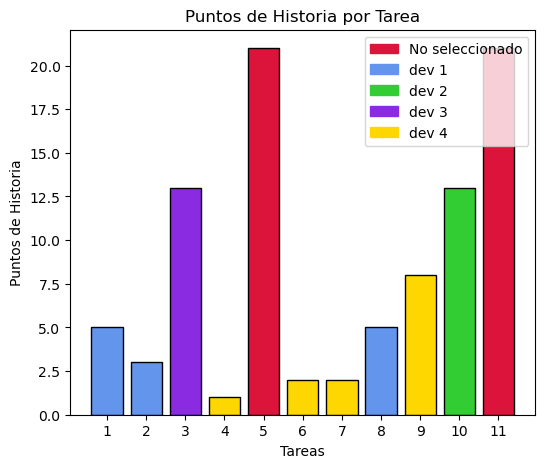

In [152]:
fig, axis = plt.subplots(figsize=(6,5))

colors_per_dev = {0: "crimson", 1: "cornflowerblue", 2: "limegreen", 3: "blueviolet", 4: "gold"}
labels = ["No seleccionado", "dev 1", "dev 2", "dev 3", "dev 4"]

colors = []
for j in model.T:
    selected = False
    for i in model.D:
        if model.X[i,j].value == 1:
            colors.append(colors_per_dev[i])
            selected = True
            break
    if not selected:
        colors.append(colors_per_dev[0])

axis.bar(range(1, tasks_num + 1), ph, color=colors, edgecolor='black')

plt.xlabel("Tareas")
plt.ylabel("Puntos de Historia")
plt.title("Puntos de Historia por Tarea")
plt.xticks(range(1, tasks_num + 1))

handles = [mpatches.Patch(color=v, label=labels[k]) for k,v in colors_per_dev.items()]
plt.legend(handles=handles, loc='upper right')

plt.show()

# Punto 2

## Parte A

## Parte B

# Punto 3

## Problema
Lo que nos dice el ejercicio es que hay una flota de 3 aviones que tiene un peso y volumen máximo que puede transportar. También hay una cantidad de recursos que tienen asignado un peso y volumen máximo, además un valor. Lo que se nos pide realizar es **maximizar** el valor de los recursos que se enviarán en la flota de aviones en la misión humanitaria hacia Zambia respetando los limites de volumen y peso de cada avión.

## Parámetros
Inicialmente tenemos $A = A_1, A_2, A_3$ aviones y $R = R_1, R_2, \dots, R_5$ recursos. Cada $i \in A$ avión puede llevar un máximo de peso $w_i$ y un máximo de volumen $v_i$. Adicionalmente, cada $j \in R$ recurso tiene un peso $w_{j}^{*}$, un volumen $v_{j}^{*}$ y un valor $p_{j}$.

## Variable de decisión
Para resolver el problema basta con definir una matriz binaria $X$ de tamaño número de aviones por número de recursos. Cada entrada de la matriz tendrá un 1 si el avión lleva el recurso, 0 de lo contrario. Por ejemplo, sí $X_{ij}$ es 1, entonces el avión $i$ lleva el recurso $j$.

In [153]:
flights = 3
resources = 5

model = ConcreteModel()

model.F = RangeSet(1, flights)
model.R = RangeSet(1, resources)

# constraints
# resources
resource_weight = [15, 5, 20, 18, 10]
resource_volume = [8, 2, 10, 12, 6]
resource_value = [50, 100, 120, 60, 40]

dict_rw = {i+1: resource_weight[i] for i in range(resources)}
dict_rv = {i+1: resource_volume[i] for i in range(resources)}
dict_rval = {i+1: resource_value[i] for i in range(resources)}

# flights
flight_wcapacity = [30, 40, 50]
flight_vcapacity = [25, 30, 35]

dict_fw = {i+1: flight_wcapacity[i] for i in range(flights)} # Weight 
dict_fv = {i+1: flight_vcapacity[i] for i in range(flights)} # Volume

# define constraints in the model
model.RW = Param(model.R, initialize=dict_rw)
model.RV = Param(model.R, initialize=dict_rv)
model.RVal = Param(model.R, initialize=dict_rval)

model.FW = Param(model.F, initialize=dict_fw)
model.FV = Param(model.F, initialize=dict_fv)

# define decision variable
model.X = Var(model.F, model.R, within=Binary)

## Función objetivo

Se debe maximizar el valor de los recursos que se llevan en la flota, por tanto, la función objetivo es la siguiente:

$$
    Z = \max \sum_{i \in A} \sum_{j\in R} X_{i, j} \times p_j
$$

In [154]:
def obj_func(model):
    return sum(model.X[i, j] * model.RVal[j] for j in model.R for i in model.F)

model.obj = Objective(rule=obj_func, sense=maximize)

## Restricciones

Ahora bien, en cuanto a las restricciones tenemos las siguientes. Por un lado debemos limitar el volumen y el peso de los recursos que llevamos en cada uno de los aviones. Para cada $i$ avión, 

$$
\sum_{j \in R} X_{i, j} \times w_{j}^{*} \leq w_i, \forall i \in A
$$

$$
        \sum_{j \in R} X_{i, j} \times v_{j}^{*} \leq v_i, \forall i \in A
$$

Adicionalmente, debemos recordar que un recurso solo se puede cargar 1 vez entre todos los aviones de la flota.

$$
        \sum_{i \in A} X_{i, j} \leq 1, \forall j \in R
$$

Otras dos restricciones que se nos da en el enunciado es que las medicinas no pueden ser trasportadas en el avión 1, y los equipos médicos no pueden ir junto al agua y viceversa. Lo que nos da como resultado las dos siguientes restricciones.

$$
        X_{1, 2} = 0
$$

$$
        X_{i, 3} + X_{i, 4} \leq 1, \forall i \in A
$$

In [155]:
def max_weight_constr(model, i):
    return sum(model.X[i, j] * model.RW[j] for j in model.R) <= model.FW[i]

model.max_weight = Constraint(model.F, rule=max_weight_constr)

def max_volume_constr(model, i):
    return sum(model.X[i, j] * model.RV[j] for j in model.R) <= model.FV[i]

model.max_volumen = Constraint(model.F, rule=max_volume_constr)

In [156]:
def one_resource_constr(model, j):
    return sum(model.X[i, j] for i in model.F) <= 1

model.one_resource = Constraint(model.R, rule=one_resource_constr)

In [157]:
def resources_constr(model, i):
    return model.X[i, 3] + model.X[i, 4] <= 1
model.resources_constr = Constraint(model.F, rule=resources_constr)

model.exclusion_constraint = Constraint(expr=model.X[1,2] == 0)

## Solución del modelo

In [158]:
solver = SolverFactory('glpk')
solver.solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\javier\AppData\Local\Temp\tmpk4or_5y_.glpk.raw --wglp C:\Users\javier\AppData\Local\Temp\tmpwf80tgbg.glpk.glp
 --cpxlp C:\Users\javier\AppData\Local\Temp\tmp_t_faf_c.pyomo.lp
Reading problem data from 'C:\Users\javier\AppData\Local\Temp\tmp_t_faf_c.pyomo.lp'...
C:\Users\javier\AppData\Local\Temp\tmp_t_faf_c.pyomo.lp:137: warning: lower bound of variable 'x2' redefined
C:\Users\javier\AppData\Local\Temp\tmp_t_faf_c.pyomo.lp:137: warning: upper bound of variable 'x2' redefined
15 rows, 15 columns, 52 non-zeros
15 integer variables, all of which are binary
152 lines were read
Writing problem data to 'C:\Users\javier\AppData\Local\Temp\tmpwf80tgbg.glpk.glp'...
114 lines were written
GLPK Integer Optimizer 5.0
15 rows, 15 columns, 52 non-zeros
15 integer variables, all of which are binary
Preprocessing...
8 constraint coefficient(s) were reduced
14 rows, 14 columns, 48 non-zeros
14 integer variables

{'Problem': [{'Name': 'unknown', 'Lower bound': 370.0, 'Upper bound': 370.0, 'Number of objectives': 1, 'Number of constraints': 15, 'Number of variables': 15, 'Number of nonzeros': 52, 'Sense': 'maximize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'optimal', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': '3', 'Number of created subproblems': '3'}}, 'Error rc': 0, 'Time': 0.04022812843322754}], 'Solution': [OrderedDict([('number of solutions', 0), ('number of solutions displayed', 0)])]}

## Resultados

In [159]:
print("### Resultados ###")
print("Tareas asignadas a cada avion\n")

for i in model.F:
    print(f"[->] Avion {i}:")
    v, w, val = 0, 0, 0
    for j in model.R:
        if model.X[i, j].value == 1:
            w += model.RW[i]
            v += model.RV[i]
            val += model.RVal[j]
            print(f"\tRecurso {j} con valor {model.RVal[j]}")
    print("\t---- STATS ----")
    print(f"\tPeso usado: {w}/{model.FW[i]} Ton")
    print(f"\tVolumen usado: {v}/{model.FV[i]} m^3")
    print(f"\tValor parcial: {val}\n")

total = sum(model.X[i, j].value * model.RVal[j] for j in model.R for i in model.F)
print(f"El valor total de los recursos que se llevan en la flota es de {total}.")

### Resultados ###
Tareas asignadas a cada avion

[->] Avion 1:
	Recurso 1 con valor 50
	---- STATS ----
	Peso usado: 15/30 Ton
	Volumen usado: 8/25 m^3
	Valor parcial: 50

[->] Avion 2:
	Recurso 2 con valor 100
	Recurso 3 con valor 120
	Recurso 5 con valor 40
	---- STATS ----
	Peso usado: 15/40 Ton
	Volumen usado: 6/30 m^3
	Valor parcial: 260

[->] Avion 3:
	Recurso 4 con valor 60
	---- STATS ----
	Peso usado: 20/50 Ton
	Volumen usado: 10/35 m^3
	Valor parcial: 60

El valor total de los recursos que se llevan en la flota es de 370.0.
